In [1]:
pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade pip setuptools wheel

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install scikit-learn --prefer-binary


Note: you may need to restart the kernel to use updated packages.


In [7]:
from web3 import Web3
import json

# Load ABI
with open("blockchain/AuthContract_abi.json", "r") as f:
    abi = json.load(f)

# Load contract address
with open("blockchain/contract_address.txt", "r") as f:
    contract_address = f.read().strip()

# Connect to Ganache
ganache_url = "http://127.0.0.1:7545"
web3 = Web3(Web3.HTTPProvider(ganache_url))

# Replace with the SAME address & private key used during deployment
my_address = web3.eth.accounts[0]
private_key = "0xb247dab77913d979915be784d263231fcd7bacf0a5a4e4d29026ab021368469d"

# Load the contract instance
contract = web3.eth.contract(address=contract_address, abi=abi)

def store_cid(uid, cid):
    nonce = web3.eth.get_transaction_count(my_address)
    tx = contract.functions.storeCID(uid, cid).build_transaction({
        'chainId': 1337,
        'gas': 6721975,
        'gasPrice': web3.to_wei('10', 'gwei'),
        'nonce': nonce,
        'from': my_address
    })

    signed_tx = web3.eth.account.sign_transaction(tx, private_key=private_key)
    tx_hash = web3.eth.send_raw_transaction(signed_tx.raw_transaction)
    receipt = web3.eth.wait_for_transaction_receipt(tx_hash)
    print(f"✅ Stored on-chain: UID = {uid}, CID = {cid}")
    return receipt

def get_cid(uid):
    try:
        cid = contract.functions.getCID(uid).call()
        print(f"📦 Retrieved from blockchain: {cid}")
        return cid
    except Exception as e:
        print("❌ Error:", str(e))
        return None


In [9]:
import numpy as np
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os
import cv2
from sklearn.datasets import fetch_lfw_people
from tensorflow.keras import Sequential


class EmbeddingAutoencoder:
    def __init__(self, model_path="models/autoencoder.h5"):
        self.model_path = model_path
        self.encoder = None
        self.autoencoder = None
        self._build_or_load()

    def _build_or_load(self):
        if os.path.exists(self.model_path):
            self.autoencoder = load_model(self.model_path)
            self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer("bottleneck").output)
        else:
            self._train_autoencoder()

    def _train_autoencoder(self):
        from sklearn.datasets import fetch_lfw_people
        from keras_facenet import FaceNet
        embedder = FaceNet()
        lfw = fetch_lfw_people(color=True, resize=0.5)
        images = (lfw.images * 255).astype(np.uint8)
        embeddings = np.array([embedder.embeddings(np.expand_dims(cv2.resize(cv2.cvtColor(img, cv2.COLOR_RGB2BGR), (160, 160)) / 255.0, axis=0))[0] for img in range(0,200)])

        input_dim = embeddings.shape[1]
        inp = Input(shape=(input_dim,))
        x = Dense(64, activation='relu')(inp)
        bottleneck = Dense(32, activation='relu', name='bottleneck')(x)
        x = Dense(64, activation='relu')(bottleneck)
        out = Dense(input_dim, activation='sigmoid')(x)
        autoencoder = Model(inputs=inp, outputs=out)
        autoencoder.compile(optimizer=Adam(0.001), loss='mse')

        X_train, X_val = train_test_split(embeddings, test_size=0.2, random_state=42)
        autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_val, X_val), verbose=1)

        self.autoencoder = autoencoder
        self.encoder = Model(autoencoder.input, autoencoder.get_layer("bottleneck").output)

        os.makedirs(os.path.dirname(self.model_path), exist_ok=True)
        autoencoder.save(self.model_path)

    def get_encoded(self, embedding):
        return self.encoder.predict(np.array([embedding]))[0]


In [43]:
import numpy as np
from keras_facenet import FaceNet
import cv2

class FaceNetEmbedder:
    def __init__(self):
        self.embedder = FaceNet()
        print("✅ FaceNet model loaded with", len(self.embedder.model.layers), "layers.")

    def get_embedding(self, face_img):
        # Step 1: Resize image to 160x160
        resized = cv2.resize(face_img, (160, 160))

        # Step 2: Normalize pixels to [0, 1]
        normalized = resized.astype('float32') / 255.0

        # Step 3: Standardize (zero mean, unit variance)
        mean, std = normalized.mean(), normalized.std()
        standardized = (normalized - mean) / (std + 1e-10)

        # Step 4: Expand dims and pass through model
        face_array = np.expand_dims(standardized, axis=0)
        embedding = self.embedder.embeddings(face_array)

        return embedding[0]


In [45]:
import numpy as np
import cv2
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics.pairwise import cosine_similarity


# Load LFW dataset
lfw = fetch_lfw_people(color=True, resize=0.5)
images = (lfw.images * 255).astype(np.uint8)
names = lfw.target_names
targets = lfw.target

# Pick two images (e.g., same person or different people)
img1 = images[0]
img2 = images[1]  # Change to 0 again for same image test

# Print who these people are
print(f"Image 1: {names[targets[0]]}")
print(f"Image 2: {names[targets[1]]}")

# Convert to BGR as FaceNet expects BGR input
img1_bgr = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
img2_bgr = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)

# Initialize FaceNet embedder
embedder = FaceNetEmbedder()

# Get embeddings
embedding1 = embedder.get_embedding(img1_bgr)
embedding2 = embedder.get_embedding(img2_bgr)

# Compute cosine similarity
similarity = cosine_similarity([embedding1], [embedding2])[0][0]

print(f"🔁 Cosine Similarity: {similarity:.4f}")

# Threshold interpretation
if similarity > 0.9:
    print("✅ Likely same person")
elif similarity > 0.7:
    print("🟡 Possibly same person")
else:
    print("❌ Likely different people")


Image 1: Tim Curry
Image 2: Mahmoud Abbas
✅ FaceNet model loaded with 448 layers.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
🔁 Cosine Similarity: 1.0000
✅ Likely same person


In [50]:
pip install keras-facenet


Note: you may need to restart the kernel to use updated packages.


In [51]:
import numpy as np
import cv2
from sklearn.datasets import fetch_lfw_people
from keras_facenet import FaceNet
from sklearn.metrics.pairwise import cosine_similarity

# Initialize FaceNet model
embedder = FaceNet()

# Load LFW data
lfw = fetch_lfw_people(color=True, resize=0.5)
images = (lfw.images * 255).astype(np.uint8)
names = lfw.target_names
targets = lfw.target

# Select two people with different labels
idx1 = 0
idx2 = 1
while targets[idx1] == targets[idx2]:
    idx2 += 1

img1 = cv2.resize(cv2.cvtColor(images[idx1], cv2.COLOR_RGB2BGR), (160, 160))
img2 = cv2.resize(cv2.cvtColor(images[idx2], cv2.COLOR_RGB2BGR), (160, 160))

# Normalize
img1 = img1.astype("float32") / 255.0
img2 = img2.astype("float32") / 255.0

# Get embeddings
embedding1 = embedder.embeddings(np.expand_dims(img1, axis=0))[0]
embedding2 = embedder.embeddings(np.expand_dims(img2, axis=0))[0]

# Cosine similarity
sim = cosine_similarity([embedding1], [embedding2])[0][0]

print(f"👤 Person 1: {names[targets[idx1]]}")
print(f"👤 Person 2: {names[targets[idx2]]}")
print(f"🔁 Cosine Similarity: {sim:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
👤 Person 1: Tim Curry
👤 Person 2: Mahmoud Abbas
🔁 Cosine Similarity: 1.0000


In [52]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
import numpy as np
import cv2

# Initialize FaceNet
embedder = FaceNetEmbedder()

# Load LFW
lfw = fetch_lfw_people(color=True, resize=0.5)
images = (lfw.images * 255).astype(np.uint8)
names = lfw.target_names
targets = lfw.target

# Select 5 random images of different people
sample_indices = [0, 1, 2, 3, 4]
embeddings = []

for idx in sample_indices:
    face = images[idx]
    face_bgr = cv2.cvtColor(face, cv2.COLOR_RGB2BGR)
    emb = embedder.get_embedding(face_bgr)
    embeddings.append(emb)
    print(f"👤 {names[targets[idx]]} → Embedding[:5]: {emb[:5]}")

# Compare pairwise cosine similarities
from sklearn.metrics.pairwise import cosine_similarity

for i in range(len(embeddings)):
    for j in range(i+1, len(embeddings)):
        sim = cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]
        print(f"🔁 {names[targets[sample_indices[i]]]} vs {names[targets[sample_indices[j]]]} → Similarity: {sim:.4f}")


✅ FaceNet model loaded with 448 layers.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
👤 Tim Curry → Embedding[:5]: [ 0.01040817  0.01323741 -0.08136159  0.03703693 -0.00583533]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
👤 Mahmoud Abbas → Embedding[:5]: [ 0.01040817  0.01323741 -0.08136159  0.03703693 -0.00583533]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
👤 Michel Charles Chretien → Embedding[:5]: [ 0.01040817  0.01323741 -0.08136159  0.03703693 -0.00583533]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
👤 Abid Hamid Mahmud Al-Tikriti → Embedding[:5]: [ 0.01040817  0.01323741 -0.08136159  0.03703693 -0.00583533]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
👤 Mona Locke → Embedding[:5]: [ 0.01040817  0.01323741 -0.08136159  0.03703693 -0.00583533]
🔁 Tim Curry vs Mahmoud Abbas → Similarity: 1.0000
🔁 Tim Curry vs Michel Charles Chretien → Similarity: 1.0000
🔁 Tim Curry vs Abid Hamid Mahmud Al-Tikriti → Similarity: 1.0000
🔁 Tim Curry vs Mona Locke → Similarity: 1.0000
🔁 Mahmoud Abbas vs Michel Charles Chretien → Similarity: 

In [58]:
import numpy as np
from keras_facenet import FaceNet

embedder = FaceNetEmbedder()

face = images[1]
img1= cv2.cvtColor(face, cv2.COLOR_RGB2BGR)

face = images[2]
img1= cv2.cvtColor(face, cv2.COLOR_RGB2BGR)

embedding1 = embedder.get_embedding(img1)
embedding2 = embedder.get_embedding(img2)

print("🔁 Random vs Ones similarity:",
      np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2)))


✅ FaceNet model loaded with 448 layers.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
🔁 Random vs Ones similarity: 1.0


In [10]:
import cv2
import uuid
import numpy as np
from sklearn.datasets import fetch_lfw_people
from face_recognition.facenet_model import FaceNetEmbedder
from face_recognition.autoencoder import EmbeddingAutoencoder
from encryption.aes_encryptor import AESEncryptor
from ipfs.ipfs_handler import IPFSHandler
#from blockchain.interact_contract import store_cid

# Load models
facenet_model = FaceNetEmbedder()
autoencoder = EmbeddingAutoencoder()
aes_encryptor = AESEncryptor()
ipfs = IPFSHandler()

# Load LFW faces
lfw = fetch_lfw_people(color=True, resize=0.5)
images = (lfw.images * 255).astype(np.uint8)
names = lfw.target_names
targets = lfw.target

print(f"📂 Loaded {len(images)} face images from LFW")

# Enroll first N users
N = 5
for i in range(N):
    face = images[i]
    label = names[targets[i]]
    uid = f"{label.replace(' ', '_')}_{uuid.uuid4().hex[:6]}"
    print(f"\n🧑‍💻 Enrolling: {uid}")

    # Convert RGB → BGR
    face_bgr = cv2.cvtColor(face, cv2.COLOR_RGB2BGR)

    # Step 1: Get FaceNet Embedding
    embedding = facenet_model.get_embedding(face_bgr)

    # Step 2: Compress via autoencoder
    compressed = autoencoder.get_encoded(embedding)

    # Step 3: Encrypt using AES
    encrypted = aes_encryptor.encrypt_vector(compressed)

    # Step 4: Upload to IPFS
    cid = ipfs.upload_bytes(encrypted, filename=f"{uid}.enc")

    # Step 5: Store on blockchain
    store_cid(uid, cid)


    print(f"✅ Enrolled {uid} → CID: {cid}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━

📂 Loaded 13233 face images from LFW

🧑‍💻 Enrolling: Tim_Curry_8e47cd
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
✅ Stored on-chain: UID = Tim_Curry_8e47cd, CID = QmZAJzE5UuuMkaYd58zppfdg4R6KSPa3dHUmUqkhjrWAZp
✅ Enrolled Tim_Curry_8e47cd → CID: QmZAJzE5UuuMkaYd58zppfdg4R6KSPa3dHUmUqkhjrWAZp

🧑‍💻 Enrolling: Mahmoud_Abbas_c5b367
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
✅ Stored on-chain: UID = Mahmoud_Abbas_c5b367, CID = QmWvntLSQBE51iCmmz9TBzh1vcgjoNNe7NqmHccwhZ2eXY
✅ Enrolled Mahmoud_Abbas_c5b367 → CID: QmWvntLSQBE51iCmmz9TBzh1vcgjoNNe7NqmHccwhZ2eXY

🧑‍💻 Enrolling: Michel_Charles_Chretien_2ba0cd
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
✅ Stored on-chain: UID = Michel_Charles_Chretien_2ba0cd, CID = QmNYzsxGF89NASReLmiu8jpCqcsxPBxsSW1FHWdXJKi8fZ
✅ Enrolled Michel_Charles_Chretien_2ba0cd → CID: QmNYzsxGF89NASReLmiu8jpCqcsxPBxsSW1FHWdXJKi8fZ

🧑‍💻 Enrolling: Abid_Hamid_Mahmud_Al-Tikriti_d41aa2

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def verify_user(uid, query_img, threshold=0.95):
    print(f"🔍 Verifying UID: {uid}")

    # Preprocess query image
    query_bgr = cv2.cvtColor(query_img, cv2.COLOR_RGB2BGR)
    embedding = facenet_model.get_embedding(query_bgr)
    compressed = autoencoder.get_encoded(embedding)
    encrypted = aes_encryptor.encrypt_vector(compressed)

    # 🔓 Retrieve and decrypt reference embedding
    cid = get_cid(uid)
    if not cid:
        print("❌ UID not found on-chain.")
        return False

    ref_encrypted = ipfs.download_bytes(cid)
    ref_compressed = aes_encryptor.decrypt_vector(ref_encrypted)

    # 🧠 Cosine Similarity
    query_vec = np.expand_dims(compressed, axis=0)
    ref_vec = np.expand_dims(ref_compressed, axis=0)
    similarity = cosine_similarity(query_vec, ref_vec)[0][0]

    print(f"🧠 Cosine similarity: {similarity:.4f}")
    if similarity >= threshold:
        print("✅ Match: Access Granted")
        return True
    else:
        print("❌ No Match: Access Denied")
        return False


In [18]:
# Pick a test image from the LFW dataset
test_index = 2  # Change this to any index (make sure it's a valid one)
test_img = images[test_index]

# Double-check the label if needed
test_label = names[targets[test_index]]
print(f"🧪 Selected test image label: {test_label}")

🧪 Selected test image label: Michel Charles Chretien


In [19]:
verify_user("Michel_Charles_Chretien_2ba0cd", test_img)


🔍 Verifying UID: Michel_Charles_Chretien_2ba0cd
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
📦 Retrieved from blockchain: QmNYzsxGF89NASReLmiu8jpCqcsxPBxsSW1FHWdXJKi8fZ
🧠 Cosine similarity: 1.0000
✅ Match: Access Granted


True

In [20]:
# Pick a test image from the LFW dataset
test_index = 2  # Change this to any index (make sure it's a valid one)
test_img = images[test_index]

# Double-check the label if needed
test_label = names[targets[test_index]]
print(f"🧪 Selected test image label: {test_label}")
verify_user("Michel_Charles_Chretien_2ba0ce", test_img)

🧪 Selected test image label: Michel Charles Chretien
🔍 Verifying UID: Michel_Charles_Chretien_2ba0ce
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
❌ Error: {'message': 'VM Exception while processing transaction: revert UID not found.', 'stack': 'CallError: VM Exception while processing transaction: revert UID not found.\n    at Blockchain.simulateTransaction (C:\\Program Files\\WindowsApps\\GanacheUI_2.7.1.0_x64__rb4352f0jd4m2\\app\\resources\\static\\node\\node_modules\\ganache\\dist\\node\\1.js:2:72658)', 'code': -32000, 'name': 'CallError', 'data': '0x08c379a00000000000000000000000000000000000000000000000000000000000000020000000000000000000000000000000000000000000000000000000000000000e554944206e6f7420666f756e642e000000000000000000000000000000000000'}
❌ UID not found on-chain.


False

In [22]:
# Pick a test image from the LFW dataset
test_index = 0 # Change this to any index (make sure it's a valid one)
test_img = images[test_index]

# Double-check the label if needed
test_label = names[targets[test_index]]
print(f"🧪 Selected test image label: {test_label}")
verify_user("Michel_Charles_Chretien_2ba0ce", test_img)

🧪 Selected test image label: Tim Curry
🔍 Verifying UID: Michel_Charles_Chretien_2ba0ce
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
❌ Error: {'message': 'VM Exception while processing transaction: revert UID not found.', 'stack': 'CallError: VM Exception while processing transaction: revert UID not found.\n    at Blockchain.simulateTransaction (C:\\Program Files\\WindowsApps\\GanacheUI_2.7.1.0_x64__rb4352f0jd4m2\\app\\resources\\static\\node\\node_modules\\ganache\\dist\\node\\1.js:2:72658)', 'code': -32000, 'name': 'CallError', 'data': '0x08c379a00000000000000000000000000000000000000000000000000000000000000020000000000000000000000000000000000000000000000000000000000000000e554944206e6f7420666f756e642e000000000000000000000000000000000000'}
❌ UID not found on-chain.


False

In [23]:
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(enrolled_data, test_data, threshold=0.95):
    y_true, y_pred, similarity_scores = [], [], []

    for uid, true_img in test_data.items():
        if uid not in enrolled_data:
            continue

        print(f"🔍 Evaluating: {uid}")
        true_face = test_data[uid]
        embedding = facenet_model.get_embedding(true_face)
        compressed = autoencoder.get_encoded(embedding)
        encrypted = aes_encryptor.encrypt_vector(compressed)

        cid = get_cid(uid)
        ref_encrypted = ipfs.download_bytes(cid)
        ref_compressed = aes_encryptor.decrypt_vector(ref_encrypted)

        sim = cosine_similarity(
            np.expand_dims(compressed, axis=0),
            np.expand_dims(ref_compressed, axis=0)
        )[0][0]

        similarity_scores.append(sim)
        y_true.append(1)  # genuine attempt
        y_pred.append(1 if sim >= threshold else 0)

        # Evaluate against others (impostors)
        for impostor_uid, impostor_img in test_data.items():
            if impostor_uid == uid:
                continue
            impostor_embedding = facenet_model.get_embedding(impostor_img)
            impostor_compressed = autoencoder.get_encoded(impostor_embedding)
            sim_impostor = cosine_similarity(
                np.expand_dims(impostor_compressed, axis=0),
                np.expand_dims(ref_compressed, axis=0)
            )[0][0]
            y_true.append(0)
            y_pred.append(1 if sim_impostor >= threshold else 0)
            similarity_scores.append(sim_impostor)

    accuracy = accuracy_score(y_true, y_pred)
    far = sum((p == 1 and t == 0) for p, t in zip(y_pred, y_true)) / y_true.count(0)
    frr = sum((p == 0 and t == 1) for p, t in zip(y_pred, y_true)) / y_true.count(1)

    print(f"\n📊 Evaluation Results (Threshold = {threshold}):")
    print(f"✅ Accuracy: {accuracy:.4f}")
    print(f"❌ FAR: {far:.4f}")
    print(f"❌ FRR: {frr:.4f}")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, similarity_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("🚀 ROC Curve")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


In [24]:
from collections import defaultdict

def get_test_data_for_enrolled(enrolled_uids, lfw, names, targets):
    test_data = {}
    used_uids = set()
    
    for i in range(len(lfw.images)):
        label = names[targets[i]]
        matching_uids = [uid for uid in enrolled_uids if uid.startswith(label.replace(' ', '_'))]

        if matching_uids and matching_uids[0] not in used_uids:
            test_img = (lfw.images[i] * 255).astype(np.uint8)
            test_img_bgr = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
            test_data[matching_uids[0]] = test_img_bgr
            used_uids.add(matching_uids[0])
        
        if len(test_data) == len(enrolled_uids):
            break

    return test_data


In [25]:
enrolled_uids = [
    "Tim_Curry_8e47cd",
    "Mahmoud_Abbas_c5b367",
    "Michel_Charles_Chretien_2ba0cd",
    "Abid_Hamid_Mahmud_Al-Tikriti_d41aa2",
    "Mona_Locke_83893d"
]


🔍 Evaluating: Tim_Curry_8e47cd
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
📦 Retrieved from blockchain: QmZAJzE5UuuMkaYd58zppfdg4R6KSPa3dHUmUqkhjrWAZp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
🔍 Evaluating: Mahmoud_Abbas_c5b367
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
📦 Retrieved from blockchain: QmWvntLSQBE51iCmmz9TBzh1vcgjoNNe7NqmHccwhZ2eXY
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
🔍 Evaluating: Michel_

C:\Users\jverma2\AppData\Local\Temp\ipykernel_23824\3729078349.py:66: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jverma2\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


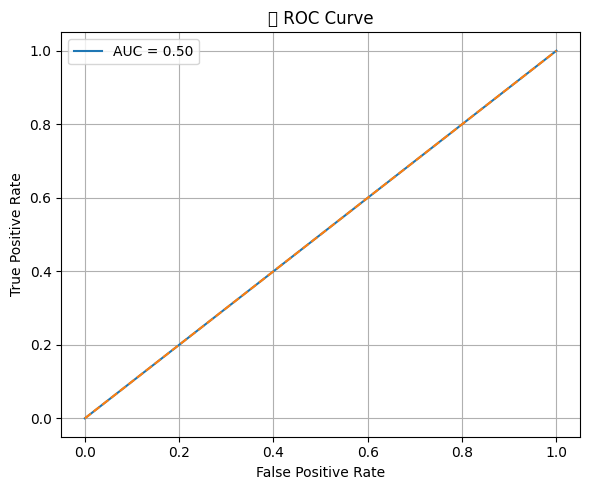

In [26]:
# Load test data
test_data = get_test_data_for_enrolled(enrolled_uids, lfw, names, targets)

# Evaluate
evaluate_model(enrolled_data=dict.fromkeys(enrolled_uids), test_data=test_data, threshold=0.95)


In [27]:
img = images[0]
face_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
emb1 = facenet_model.get_embedding(face_bgr)
emb2 = facenet_model.get_embedding(face_bgr)
sim = cosine_similarity([emb1], [emb2])[0][0]
print(f"🔁 Consistency Test → Cosine Similarity: {sim:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
🔁 Consistency Test → Cosine Similarity: 1.0000


In [30]:
def generate_similarity_scores(uids, images, model, encoder, decryptor, ipfs_handler):
    pos_scores = []
    neg_scores = []

    for i, uid in enumerate(uids):
        print(f"🔍 Processing: {uid}")
        img1 = images[i]

        # Get genuine (same UID) embedding
        emb1 = model.get_embedding(cv2.cvtColor(img1, cv2.COLOR_RGB2BGR))
        emb1 = encoder.get_encoded(emb1)

        # Load stored embedding from blockchain
        cid = get_cid(uid)
        encrypted_data = ipfs_handler.download_bytes(cid)
        ref_vec = decryptor.decrypt_vector(encrypted_data)

        # Positive (Genuine)
        sim = cosine_similarity([emb1], [ref_vec])[0][0]
        pos_scores.append(sim)

        # Negative (Impostor): compare with next 3 random users
        for j in range(len(uids)):
            if i == j:
                continue
            img2 = images[j]
            emb2 = model.get_embedding(cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))
            emb2 = encoder.get_encoded(emb2)
            sim = cosine_similarity([emb2], [ref_vec])[0][0]
            neg_scores.append(sim)

            if len(neg_scores) >= 3:  # Limit impostor pairs to reduce time
                break

    return pos_scores, neg_scores


In [31]:
pos_scores, neg_scores = generate_similarity_scores(
    uids=enrolled_uids,
    images=images[:len(enrolled_uids)],
    model=facenet_model,
    encoder=autoencoder,
    decryptor=aes_encryptor,
    ipfs_handler=ipfs
)


🔍 Processing: Tim_Curry_8e47cd
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
📦 Retrieved from blockchain: QmZAJzE5UuuMkaYd58zppfdg4R6KSPa3dHUmUqkhjrWAZp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
🔍 Processing: Mahmoud_Abbas_c5b367
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
📦 Retrieved from blockchain: QmWvntLSQBE51iCmmz9TBzh1vcgjoNNe7NqmHccwhZ2eXY
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
🔍 Processing: Michel_Charles_Chretien_2ba0cd
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
📦 Retrieved from blockchain: QmNYzsxGF89NASReLmiu8jpCqcsxPBxsSW1FHWdXJKi8fZ
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
🔍 Processing: Abid_Hamid_Mahmud_Al-Tikriti_d41aa2
1/

In [28]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def find_best_threshold(y_true, similarity_scores):
    fpr, tpr, thresholds = roc_curve(y_true, similarity_scores)
    youdens_index = tpr - fpr
    best_idx = np.argmax(youdens_index)
    best_threshold = thresholds[best_idx]

    # Plot
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.2f}')
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
    plt.scatter(fpr[best_idx], tpr[best_idx], c='red', label=f'Best Threshold = {best_threshold:.2f}')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("🎯 ROC Curve with Best Threshold")
    plt.legend()
    plt.grid()
    plt.show()

    return best_threshold


C:\Users\jverma2\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


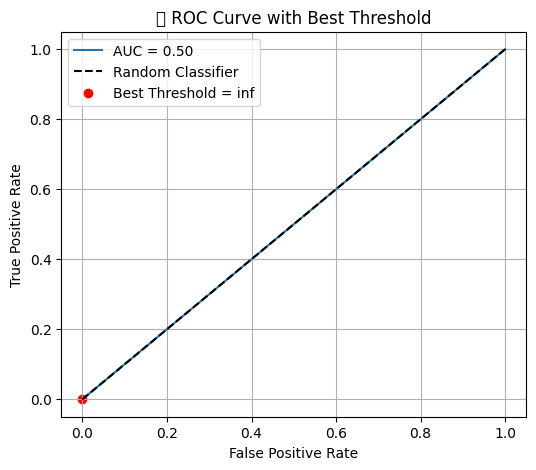

🚀 Best Threshold from ROC: inf


In [32]:
# Assume:
# pos_scores = [0.94, 0.91, 0.96, ...]
# neg_scores = [0.62, 0.73, 0.81, ...]

y_true = [1]*len(pos_scores) + [0]*len(neg_scores)
all_scores = pos_scores + neg_scores

best_threshold = find_best_threshold(y_true, all_scores)
print(f"🚀 Best Threshold from ROC: {best_threshold:.4f}")


C:\Users\jverma2\AppData\Local\Temp\ipykernel_23824\1030077778.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(pos_scores, label="✅ Genuine", fill=True)
C:\Users\jverma2\AppData\Local\Temp\ipykernel_23824\1030077778.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(neg_scores, label="❌ Impostor", fill=True)
C:\Users\jverma2\AppData\Local\Temp\ipykernel_23824\1030077778.py:14: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jverma2\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


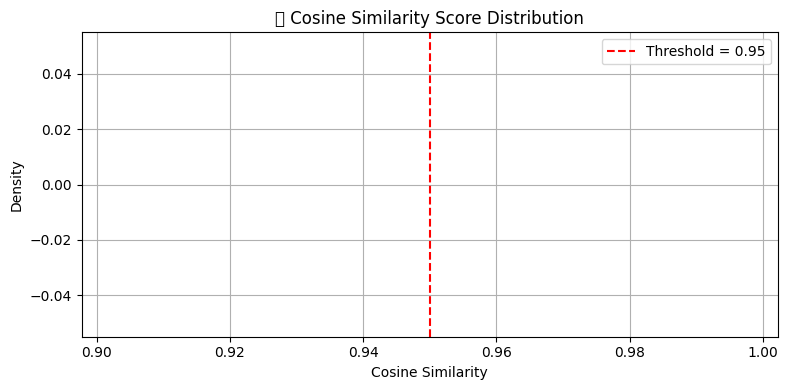

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_score_distributions(pos_scores, neg_scores):
    plt.figure(figsize=(8, 4))
    sns.kdeplot(pos_scores, label="✅ Genuine", fill=True)
    sns.kdeplot(neg_scores, label="❌ Impostor", fill=True)
    plt.axvline(0.95, color='r', linestyle='--', label='Threshold = 0.95')
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Density")
    plt.title("📊 Cosine Similarity Score Distribution")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_score_distributions(pos_scores,neg_scores)


In [35]:
from sklearn.metrics.pairwise import cosine_similarity

def verify_user(uid, query_img, return_similarity=False):
    ref_cid = get_cid(uid)
    encrypted_ref = ipfs.download_bytes(ref_cid)

    ref_compressed = aes_encryptor.decrypt_vector(encrypted_ref)
    query_embedding = facenet_model.get_embedding(query_img)
    query_compressed = autoencoder.get_encoded(query_embedding)

    # Compute cosine similarity
    query_vec = np.expand_dims(query_compressed, axis=0)
    ref_vec = np.expand_dims(ref_compressed, axis=0)
    similarity = cosine_similarity(query_vec, ref_vec)[0][0]

    if return_similarity:
        return similarity
    return similarity >= 0.95


In [36]:
pos_scores = []
neg_scores = []

for i, uid in enumerate(enrolled_uids[:10]):
    img = images[i]
    sim = verify_user(uid, img, return_similarity=True)
    pos_scores.append(sim)

    # Random impostor test
    for j in range(i + 1, i + 3):
        if j < len(enrolled_uids):
            imp_uid = enrolled_uids[j]
            imp_sim = verify_user(imp_uid, img, return_similarity=True)
            neg_scores.append(imp_sim)


📦 Retrieved from blockchain: QmZAJzE5UuuMkaYd58zppfdg4R6KSPa3dHUmUqkhjrWAZp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
📦 Retrieved from blockchain: QmWvntLSQBE51iCmmz9TBzh1vcgjoNNe7NqmHccwhZ2eXY
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
📦 Retrieved from blockchain: QmNYzsxGF89NASReLmiu8jpCqcsxPBxsSW1FHWdXJKi8fZ
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
📦 Retrieved from blockchain: QmWvntLSQBE51iCmmz9TBzh1vcgjoNNe7NqmHccwhZ2eXY
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
📦 Retrieved from blockchain: QmNYzsxGF89NASReLmiu8jpCqcsxPBxsSW1FHWdXJKi8fZ
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
📦 Retrieved from blockchain: QmVikUFPXrmjknUYMpkq4QoJbq2XNxVeF9jN3yayL9NEqv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
📦 Retrieved from blockchain: QmNYzsxGF89NASReLmiu8jpCqcsxPBxsSW1FHWdXJKi8fZ
1/1 ━━━━━━━━

C:\Users\jverma2\AppData\Local\Temp\ipykernel_23824\1030077778.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(pos_scores, label="✅ Genuine", fill=True)
C:\Users\jverma2\AppData\Local\Temp\ipykernel_23824\1030077778.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(neg_scores, label="❌ Impostor", fill=True)
C:\Users\jverma2\AppData\Local\Temp\ipykernel_23824\1030077778.py:14: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jverma2\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


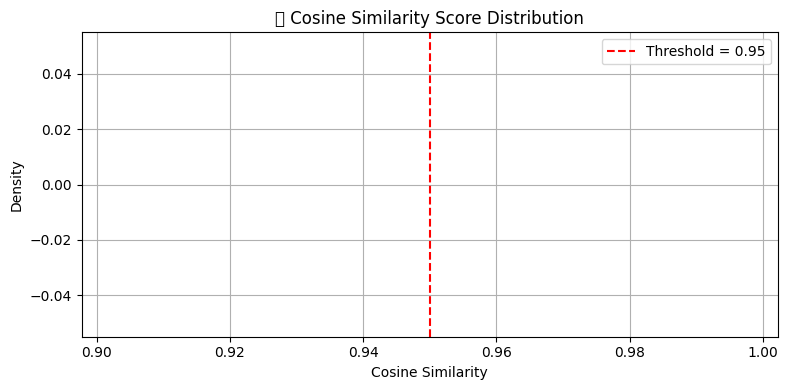

In [37]:
plot_score_distributions(pos_scores, neg_scores)


In [38]:
print("Positives:", pos_scores)
print("Negatives:", neg_scores)


Positives: [np.float64(0.9999999999999999), np.float64(0.9999999999999999), np.float64(0.9999999999999999), np.float64(0.9999999999999999), np.float64(0.9999999999999999)]
Negatives: [np.float64(0.9999999999999999), np.float64(0.9999999999999999), np.float64(0.9999999999999999), np.float64(0.9999999999999999), np.float64(0.9999999999999999), np.float64(0.9999999999999999), np.float64(0.9999999999999999)]


In [39]:
def debug_embeddings(uid, query_img):
    ref_cid = get_cid(uid)
    encrypted_ref = ipfs.download_bytes(ref_cid)

    ref_compressed = aes_encryptor.decrypt_vector(encrypted_ref)
    query_embedding = facenet_model.get_embedding(query_img)
    query_compressed = autoencoder.get_encoded(query_embedding)

    print(f"👉 Ref (from blockchain): {ref_compressed[:5]}")
    print(f"👉 Query (from image):    {query_compressed[:5]}")

    # Cosine similarity
    from sklearn.metrics.pairwise import cosine_similarity
    sim = cosine_similarity([ref_compressed], [query_compressed])[0][0]
    print(f"🔁 Cosine Similarity: {sim:.4f}")


In [40]:
debug_embeddings("Michel_Charles_Chretien_2ba0cd", images[2])


📦 Retrieved from blockchain: QmNYzsxGF89NASReLmiu8jpCqcsxPBxsSW1FHWdXJKi8fZ
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
👉 Ref (from blockchain): [2.295687437057495, 2.5261988639831543, 0.0, 0.0, 0.0]
👉 Query (from image):    [2.2956874 2.5261989 0.        0.        0.       ]
🔁 Cosine Similarity: 1.0000


In [41]:
for i in range(3):
    embedding = facenet_model.get_embedding(images[i])
    compressed = autoencoder.get_encoded(embedding)
    print(f"Embedding {i}: {compressed[:5]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Embedding 0: [2.2956874 2.5261989 0.        0.        0.       ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Embedding 1: [2.2956874 2.5261989 0.        0.        0.       ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Embedding 2: [2.2956874 2.5261989 0.        0.        0.       ]


In [42]:
pip show keras-facenet


Name: keras-facenet
Version: 0.3.2
Summary: A package wrapping the FaceNet embedding model
Home-page: https://github.com/faustomorales/keras-facenet
Author: Fausto Morales
Author-email: faustomorales@gmail.com
License: MIT
Location: c:\Users\jverma2\AppData\Local\Programs\Python\Python312\Lib\site-packages
Requires: mtcnn
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [1]:
from keras_facenet import FaceNet
import numpy as np
import cv2
from sklearn.datasets import fetch_lfw_people

# Load one RGB image from LFW
lfw = fetch_lfw_people(color=True, resize=0.5)
img = (lfw.images[0] * 255).astype(np.uint8)
img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
resized = cv2.resize(img_bgr, (160, 160))
normalized = resized.astype("float32") / 255.0
input_array = np.expand_dims(normalized, axis=0)

# Load FaceNet
facenet = FaceNet()
embeddings = facenet.embeddings(input_array)

print("✅ Embedding shape:", embeddings.shape)
print("✅ Embedding[:5]:", embeddings[0][:5])



1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
✅ Embedding shape: (1, 512)
✅ Embedding[:5]: [ 0.01040817  0.01323741 -0.08136159  0.03703693 -0.00583533]
